## 1) train, test data 불러오기 (투,타)

In [2]:
import pandas as pd
import numpy as np

In [3]:
## train

pitcher_train = pd.read_csv("/content/drive/My Drive/big_contest_2020_summer-master/eda_code/data/private_pitcher.csv")
batter_train = pd.read_csv("/content/drive/My Drive/big_contest_2020_summer-master/eda_code/data/private_batter.csv")

In [4]:
## test

pitcher_test = pd.read_csv("/content/drive/My Drive/big_contest_2020_summer-master/modeling_code/test_data/private_pitcher_test.csv", index_col  = 0)
batter_test = pd.read_csv("/content/drive/My Drive/big_contest_2020_summer-master/modeling_code/test_data/private_batter_test.csv", index_col  = 0)

In [5]:
print(pitcher_train.shape)
print(batter_train.shape)

print(pitcher_test.shape)
print(batter_test.shape)

(27804, 22)
(81102, 14)
(168, 14)
(165, 11)


* 투수

In [6]:
pitcher_train.columns

Index(['GDAY_DS', 'T_ID', 'P_ID', 'TB_SC', 'INN2', 'BF', 'PA-AB', 'AB', 'HIT',
       'H1', 'H2', 'H3', 'HR', 'SB_SR', 'KK', 'WP', 'ER', 'ERA', 'SLG',
       'BABIP', 'KK9', 'BB9'],
      dtype='object')

In [7]:
pitcher_test.columns

Index(['T_ID', 'P_ID', 'TB_SC', 'INN2', 'PA-AB', 'H1', 'H2', 'H3', 'HR',
       'SB_SR', 'WP', 'BABIP', 'KK9', 'BB9'],
      dtype='object')

=> Gameday, 'BF', 'AB', 'HIT', 'KK', 'ER', 'ERA', 'SLG' 빠짐

* 타자

In [8]:
batter_train.columns

Index(['GDAY_DS', 'T_ID', 'P_ID', 'TB_SC', 'PA-AB', 'AB', 'RUN', 'RBI', 'HIT',
       'SH+SF', 'KK', 'AVG', 'SB_trial', 'BABIP'],
      dtype='object')

In [9]:
batter_test.columns

Index(['T_ID', 'P_ID', 'TB_SC', 'PA-AB', 'AB', 'RUN', 'RBI', 'SH+SF', 'KK',
       'SB_trial', 'BABIP'],
      dtype='object')

=> Gameday, 'Hit', 'Avg' 빠짐

* train, test 모두에서
투수에서 : gameday, era, t_id, p_id를 drop하고
타자에서 : gameday, avg,t_id, p_id를 drop한다. + test에 없는 train의 feature들을 drop

In [10]:
batter_train.drop(columns = ['GDAY_DS','AVG'], inplace = True)
pitcher_train.drop(columns = ['GDAY_DS','ERA'], inplace = True)

In [11]:
pitcher_train.drop(columns = ['T_ID','P_ID'], inplace = True)
batter_train.drop(columns = ['T_ID','P_ID'], inplace = True)

pitcher_train.drop(columns = ['BF','AB'], inplace = True)
pitcher_train.drop(columns = ['HIT','KK'], inplace = True)
pitcher_train.drop(columns = ['SLG'], inplace = True)

pitcher_test.drop(columns = ['T_ID','P_ID'], inplace = True)
batter_test.drop(columns = ['T_ID','P_ID'], inplace = True)

In [12]:
print(pitcher_train.shape)
print(pitcher_test.shape)

print(batter_train.shape)
print(batter_test.shape)

(27804, 13)
(168, 12)
(81102, 10)
(165, 9)


## 2) 모델 학습

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


* 2-1) 투수

In [14]:
pitcher_train.dtypes

TB_SC     object
INN2       int64
PA-AB      int64
H1         int64
H2         int64
H3         int64
HR         int64
SB_SR    float64
WP         int64
ER         int64
BABIP    float64
KK9      float64
BB9      float64
dtype: object

In [15]:
cat_features = ['TB_SC']
pitcher_train[cat_features] = pitcher_train[cat_features].astype('category')

pitcher_train.dtypes

TB_SC    category
INN2        int64
PA-AB       int64
H1          int64
H2          int64
H3          int64
HR          int64
SB_SR     float64
WP          int64
ER          int64
BABIP     float64
KK9       float64
BB9       float64
dtype: object

In [16]:
pitcher_test[cat_features] = pitcher_test[cat_features].astype('category')

pitcher_test.dtypes

TB_SC    category
INN2      float64
PA-AB     float64
H1        float64
H2        float64
H3        float64
HR        float64
SB_SR     float64
WP        float64
BABIP     float64
KK9       float64
BB9       float64
dtype: object

In [17]:
X = pitcher_train.drop(columns = ['ER'])
y = pitcher_train['ER']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2020)

print(X_train.shape)
print(X_val.shape)
print(X.shape)

(19462, 12)
(8342, 12)
(27804, 12)


In [18]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

* XGBoostRegressor

In [19]:
# same code again (not needed but doesn't bite)
cat_features = ['TB_SC']
pitcher_train[cat_features] = pitcher_train[cat_features].astype('category')

pitcher_train.dtypes

TB_SC    category
INN2        int64
PA-AB       int64
H1          int64
H2          int64
H3          int64
HR          int64
SB_SR     float64
WP          int64
ER          int64
BABIP     float64
KK9       float64
BB9       float64
dtype: object

->  xgboost에서는 더미코딩이 필요하다

In [20]:
pitcher_train = pd.get_dummies(pitcher_train)
pitcher_train.head()

,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,ER,BABIP,KK9,BB9,TB_SC_B,TB_SC_T
0,6,1,1,0,0,0,0.0,0,0,0.250000,13.50,4.50,1,0
1,5,2,2,0,0,0,0.0,0,0,0.400000,5.40,5.40,1,0
2,1,0,1,0,0,0,0.0,0,0,0.500000,0.00,0.00,1,0
3,18,3,7,2,0,0,0.0,0,4,0.428571,6.00,1.50,1,0
4,4,2,0,1,0,0,0.0,0,1,0.333333,6.75,6.75,0,1


In [21]:
pitcher_test = pd.get_dummies(pitcher_test)
pitcher_test.head()

,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9,TB_SC_B,TB_SC_T
0,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23,1,0
1,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02,1,0
2,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99,0,1
3,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16,0,1
4,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59,0,1


In [22]:
X = pitcher_train.drop(columns = ['ER'])
y = pitcher_train['ER']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2020)

print(X_train.shape)
print(X_val.shape)

print(X.shape)

(19462, 13)
(8342, 13)
(27804, 13)


* Gridsearch

In [23]:
colsample_bytree = [0.5, 0.7, 1]
subsample = [0, 0.5, 1]
gamma = [0, 2]
learning_rate = [0.01, 0.1]
n_estimators = [300, 400, 500]

param_grid = dict(learning_rate = learning_rate,
                  n_estimators=n_estimators, colsample_bytree = colsample_bytree, subsample = subsample, gamma = gamma)

In [24]:
xgb_model = XGBRegressor()
                                
print("GRID SEARCH START")
grid_search = GridSearchCV(xgb_model, param_grid, scoring= "neg_mean_squared_error")
grid_result = grid_search.fit(X_train, y_train)

GRID SEARCH START
[23:40:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:40:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now depreca

In [25]:
print(grid_result.best_score_)

print(grid_result.best_params_)

print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = -grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

-0.5527986712720427
{'colsample_bytree': 0.7, 'gamma': 2, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5}

Best: -0.552799 using {'colsample_bytree': 0.7, 'gamma': 2, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5}


In [26]:
for mean, stdev, param in zip(means, stds, params):
    print("\n%f (%f) with: %r" % (mean, stdev, param))


3.155256 (0.108460) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 0}

0.742258 (0.041200) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 0.5}

0.742766 (0.042323) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 1}

3.155256 (0.108460) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 0}

0.674392 (0.034194) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 0.5}

0.679133 (0.035043) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 1}

3.155256 (0.108460) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0}

0.639981 (0.030096) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 500, 'subsample':

In [27]:
y_pred2 = grid_search.predict(X_val)
xgb_rmse = sqrt(mean_squared_error(y_val, y_pred2))
xgb_mse = mean_squared_error(y_val, y_pred2)
print(xgb_rmse, xgb_mse)

0.7452279993505693 0.5553647710160521


In [28]:
pitcher_predicted_xgb = grid_search.predict(pitcher_test)
pitcher_predicted_xgb

array([ 3.06063831e-01, -5.25774360e-02,  1.37962699e-02,  1.23349583e+00,
        3.35893488e+00,  2.48360395e+00,  1.12336290e+00,  4.45523322e-01,
        2.47877312e+00,  1.08011425e-01,  7.41981268e-02,  1.79105788e-01,
        6.54479563e-02,  3.16392827e+00,  1.43913555e+00, -2.01634765e-02,
        2.60857165e-01,  1.76123679e-02, -3.56720090e-02,  3.25073457e+00,
        3.19209313e+00,  1.12742573e-01,  1.85871571e-01,  1.53681469e+00,
        5.35542667e-02,  1.65728045e+00,  2.04368138e+00, -1.25163794e-03,
        4.24302197e+00,  1.88212782e-01,  3.39168519e-01, -1.09725595e-02,
        4.88274992e-02,  1.25821859e-01,  1.01042867e-01,  1.12458825e+00,
        1.21141136e-01,  2.76509523e-02,  3.97536814e-01,  2.88094306e+00,
        1.10515249e+00,  1.66665554e+00,  1.37962699e-02,  2.21491504e+00,
        1.22116566e-01,  3.08890998e-01,  3.27123690e+00,  9.40715373e-02,
       -7.97530413e-02,  4.05427814e-01, -1.14071429e-01,  1.26684439e+00,
        3.20999861e+00,  

In [29]:
xgb_feature_importance_pitcher = grid_search.best_estimator_.feature_importances_
xgb_feature_imp_pitcher = pd.Series(xgb_feature_importance_pitcher,index=X_train.columns).sort_values(ascending=False)
xgb_feature_imp_pitcher

HR         0.394617
H1         0.167712
H2         0.124268
BABIP      0.078179
PA-AB      0.064565
INN2       0.046769
H3         0.039714
BB9        0.029663
KK9        0.014247
WP         0.013681
TB_SC_B    0.011262
SB_SR      0.010069
TB_SC_T    0.005255
dtype: float32

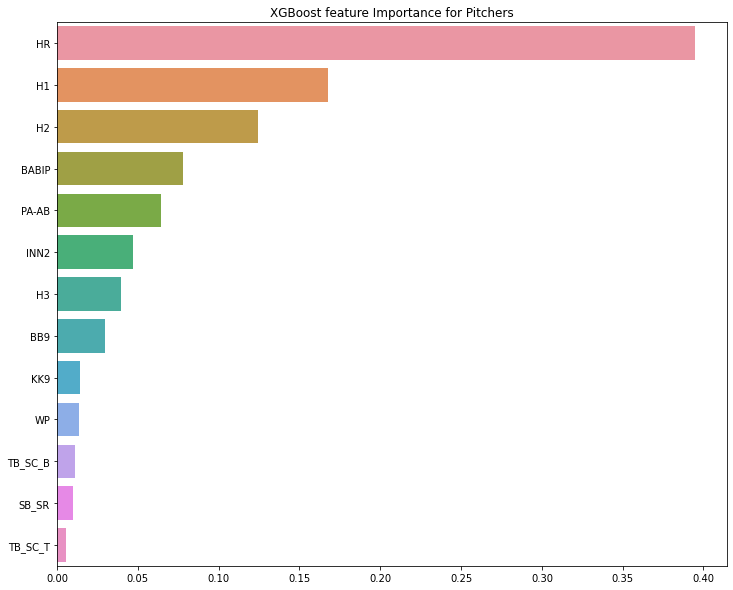

In [30]:
plt.figure(figsize=(12,10))
plt.title("XGBoost feature Importance for Pitchers")
sns.barplot(x=xgb_feature_imp_pitcher[0:30], y=xgb_feature_imp_pitcher.index[0:30])

In [31]:
pitcher_test.head()

,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9,TB_SC_B,TB_SC_T
0,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23,1,0
1,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02,1,0
2,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99,0,1
3,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16,0,1
4,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59,0,1


In [32]:
pitcher_test = pd.read_csv("/content/drive/My Drive/big_contest_2020_summer-master/modeling_code/test_data/private_pitcher_test.csv", index_col  = 0)
pitcher_test.head()

,T_ID,P_ID,TB_SC,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9
0,OB,77263,B,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23
1,NC,63959,B,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02
2,NC,61295,T,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99
3,SK,60841,T,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16
4,LT,64021,T,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59


In [33]:
pitcher_test['ER'] = np.round(pitcher_predicted_xgb,2)

In [34]:
pitcher_test.head()

,T_ID,P_ID,TB_SC,INN2,PA-AB,H1,H2,H3,HR,SB_SR,WP,BABIP,KK9,BB9,ER
0,OB,77263,B,2.77,0.72,0.81,0.21,0.08,0.01,0.01,0.03,0.37,8.28,10.23,0.31
1,NC,63959,B,2.09,0.43,0.45,0.05,0.00,0.01,0.00,0.00,0.26,6.03,7.02,-0.05
2,NC,61295,T,3.26,0.52,0.64,0.08,0.00,0.26,0.05,0.00,0.20,6.17,3.99,0.01
3,SK,60841,T,15.77,3.26,4.08,0.74,0.11,0.43,0.63,0.08,0.33,8.07,6.16,1.23
4,LT,64021,T,14.93,2.50,3.96,0.91,0.05,0.69,0.36,0.66,0.31,6.81,4.59,3.36


In [35]:
pitcher_test.to_csv("/content/drive/My Drive/big_contest_2020_summer-master/modeling_code/report_data/private_pitcher_report_xgb.csv")

## 2-2)타자

In [36]:
cat_features = ['TB_SC']
batter_train[cat_features] = batter_train[cat_features].astype('category')

batter_train.dtypes

TB_SC       category
PA-AB          int64
AB             int64
RUN            int64
RBI            int64
HIT            int64
SH+SF          int64
KK             int64
SB_trial       int64
BABIP        float64
dtype: object

In [37]:
batter_train = pd.get_dummies(batter_train)
batter_train.head()

batter_test = pd.get_dummies(batter_test)
batter_test.head()

,PA-AB,AB,RUN,RBI,SH+SF,KK,SB_trial,BABIP,TB_SC_B,TB_SC_T
0,0.37,4.01,0.73,0.45,0.08,0.38,0.07,0.35,1,0
1,0.14,2.08,0.31,0.33,0.03,0.37,0.26,0.15,1,0
2,0.21,3.74,0.61,0.28,0.03,0.46,0.14,0.31,0,1
3,0.14,1.58,0.19,0.26,0.05,0.23,0.00,0.24,1,0
4,0.20,3.07,0.24,0.34,0.07,0.82,0.20,0.17,0,1


In [38]:
print(batter_train.columns)

print(batter_test.columns)

Index(['PA-AB', 'AB', 'RUN', 'RBI', 'HIT', 'SH+SF', 'KK', 'SB_trial', 'BABIP',
       'TB_SC_B', 'TB_SC_T'],
      dtype='object')
Index(['PA-AB', 'AB', 'RUN', 'RBI', 'SH+SF', 'KK', 'SB_trial', 'BABIP',
       'TB_SC_B', 'TB_SC_T'],
      dtype='object')


In [39]:
X = batter_train.drop(columns = ['HIT'])
y = batter_train['HIT']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 2020)

print(X_train.shape)
print(X_val.shape)

print(X.shape)

(56771, 10)
(24331, 10)
(81102, 10)


In [40]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

In [41]:
colsample_bytree = [0.5, 0.7, 1]
subsample = [0, 0.5, 1]
gamma = [0, 2]
learning_rate = [0.01, 0.1]
n_estimators = [300, 400, 500]

param_grid = dict(learning_rate = learning_rate,
                  n_estimators=n_estimators, colsample_bytree = colsample_bytree, subsample = subsample, gamma = gamma)

In [42]:
xgb_model = XGBRegressor()
                                
print("GRID SEARCH START")
grid_search = GridSearchCV(xgb_model, param_grid, scoring= "neg_mean_squared_error")
grid_result = grid_search.fit(X_train, y_train)

GRID SEARCH START
[00:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now depreca

In [43]:
print(grid_result.best_score_)

print(grid_result.best_params_)

print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = -grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

-0.010871624623745921
{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.5}

Best: -0.010872 using {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.5}


In [44]:
for mean, stdev, param in zip(means, stds, params):
    print("\n%f (%f) with: %r" % (mean, stdev, param))


0.893498 (0.011249) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 0}

0.088772 (0.002179) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 0.5}

0.085166 (0.001897) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 300, 'subsample': 1}

0.893498 (0.011249) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 0}

0.068897 (0.001902) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 0.5}

0.064031 (0.001606) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 400, 'subsample': 1}

0.893498 (0.011249) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0}

0.058449 (0.001730) with: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 500, 'subsample':

In [45]:
y_pred3 = grid_search.predict(X_val)
xgb_rmse_batter = sqrt(mean_squared_error(y_val, y_pred3))
xgb_mse_batter = mean_squared_error(y_val, y_pred3)
print(xgb_rmse_batter, xgb_mse_batter)

0.0996280999126501 0.009925758292204991


In [46]:
y_val

28054    1
30685    1
70486    0
73490    0
57030    0
        ..
16953    2
79929    0
17902    2
66090    0
71423    1
Name: HIT, Length: 24331, dtype: int64

In [47]:
batter_test = batter_test.rename(columns = {"PA-AB" : "PA_AB", "SH+SF":"SH_SF"})
batter_test.columns

batter_predicted_xgb = grid_search.predict(batter_test)
batter_predicted_xgb

array([ 1.3234031e+00,  7.7289796e-01,  1.3263094e+00,  8.0907965e-01,
        7.6271272e-01,  2.3907423e-03,  9.7346723e-01,  1.3180733e+00,
        8.5087180e-01,  7.0023119e-01,  8.3238876e-01,  8.8791919e-01,
        7.7289796e-01,  7.5741822e-01,  7.6512229e-01,  7.8234231e-01,
        7.5764072e-01,  7.7312046e-01,  7.7312046e-01,  7.0426279e-01,
        1.0039012e+00,  7.7771759e-01,  7.8790283e-01,  7.4305171e-01,
        8.3238876e-01,  8.9399195e-01, -1.3778210e-03,  9.3763697e-01,
        8.3238876e-01,  7.5991648e-01,  6.8573910e-01, -1.3778210e-03,
        1.1864223e+00,  1.3096734e+00,  7.0121884e-01,  9.6667165e-01,
       -1.3778210e-03,  8.3154213e-01,  7.6271272e-01,  1.3133664e+00,
        1.0107527e+00,  7.0121884e-01,  1.5451699e+00,  1.0752708e+00,
        7.8790283e-01, -1.1552572e-03,  7.5107086e-01,  9.6667165e-01,
        7.8776062e-01, -4.5807362e-03,  7.7326775e-01,  7.8790283e-01,
        8.2556963e-01,  6.8573910e-01,  1.3180733e+00,  1.6381359e+00,
      

In [48]:
xgb_feature_importance_batter = grid_search.best_estimator_.feature_importances_
xgb_feature_imp_batter=pd.Series(xgb_feature_importance_batter,index=X_train.columns).sort_values(ascending=False)
xgb_feature_imp_batter

BABIP       0.564411
AB          0.190466
KK          0.095772
RBI         0.084634
RUN         0.055519
SH_SF       0.003658
PA_AB       0.003450
SB_trial    0.001447
TB_SC_B     0.000643
TB_SC_T     0.000000
dtype: float32

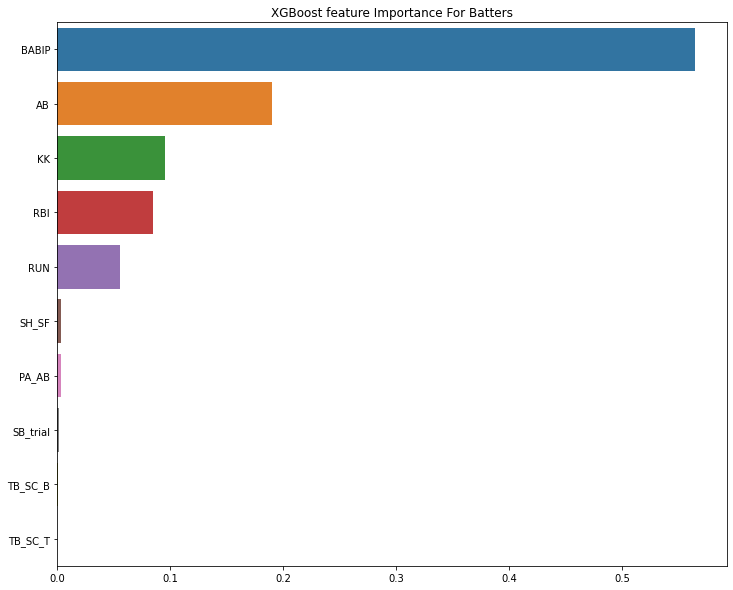

In [49]:
plt.figure(figsize=(12,10))
plt.title("XGBoost feature Importance For Batters")
sns.barplot(x=xgb_feature_imp_batter[0:30], y=xgb_feature_imp_batter.index[0:30])

In [50]:
batter_test = pd.read_csv("/content/drive/My Drive/big_contest_2020_summer-master/modeling_code/test_data/private_batter_test.csv", index_col  = 0)

In [51]:
batter_test['HIT'] = np.round(batter_predicted_xgb,2)

In [52]:
batter_test.to_csv("/content/drive/My Drive/big_contest_2020_summer-master/modeling_code/report_data/private_batter_report_xgb.csv")
